In [315]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lasio

from SCA_DEM_ani import sca_ani_0113, dem_ani
from wei6_processing import (
    read_las_wei6,
    build_standard_log_frame,
    quick_check,
)

from rock_utils import Backus_mult241016, Schoenberg, BKG, compute_vsh_from_gr

from rock_utils import C2T, ku2c, ku2c_iso

plt.rcParams['figure.figsize'] = (5, 8)
plt.rcParams['axes.grid'] = True

In [316]:
# 1. 读取 WEI6.las
las_path = "/root/inversion/well/mineral/WEI6_mineral.las"   # 根据你实际路径改

las = lasio.read(las_path)

# 1) 转成 DataFrame（lasio 会自动用 NULL 值转为 NaN）
df = las.df()  # 行索引就是 depth
df.index.name = "DEPTH"

# 2) 额外再替换一些常见的空值编码
NULL_VALUES = [-999.25, -999.0, 999.25, 999.0, 1e30]
df = df.replace(NULL_VALUES, np.nan)

STANDARD_CURVE_MAP = {
    # 标准名 : LAS 文件里可能的候选名（按优先级）
    "GR": ["GR1", "CGR"],
    "RHOB": ["ZDEN", "DEN"],      # 体积密度
    "DT": ["DT24", "AC", "DTC"],  # 声波时差
    "DTS": ["DTS"],  # 声波时差
    "CNCF": ["CNCF","CN"],
    "PHI": ["POR","POR", "PORDN1"],     # 孔隙度（总 / 中子 / 密度等，可按需要改）
    # 粘土
    "SH": ["SH"],
    "SW": ["SW1"],
    # 视电阻率
    "RT_DEEP": ["RTT", "RLD", "RT"],
    "RT_MED": ["RMLL", "R40", "RLLD", "RLLS"],
    "LLD": ["RLD"],
    "LLS": ["RMLL"],
    # 其它可以按需要自己补
    "CALC": ["CALC"],    # 方解石 (Calcite)?
    "PE": ["PE"],
    "V_FRAMEWORK": ["V_FRAMEWORK"],
    "V_CLAY": ["V_CLAY"],
    "V_DOLOMITE": ["V_DOLOMITE"],

}

df_new = build_standard_log_frame(df, curve_map=STANDARD_CURVE_MAP)

# === 截取目标深度段 (1723.00, 1972.60) ===
depth_min, depth_max = 1800.00, 2200
df_new = df_new[(df_new.index >= depth_min) & (df_new.index <= depth_max)]

print(f"Depth range filtered: {df_new.index.min()} - {df_new.index.max()}")
print(df_new.head())

Depth range filtered: 1800.04736 - 2199.94507
                 GR   RHOB      DT        DTS    CNCF    PHI        SH     SW  \
DEPTH                                                                           
1800.04736  125.970  2.407  94.390  170.30299  29.538  0.001  86.87005  100.0   
1800.12366  125.428  2.425  90.291  165.39200  25.622  0.001  85.23008  100.0   
1800.19983  122.993  2.468  85.097  165.39200  22.392  0.001  78.20397  100.0   
1800.27600  122.993  2.468  85.097  158.63800  22.392  0.001  78.20397  100.0   
1800.35217  118.124  2.523  80.012  158.63800  21.106  0.001  65.69735  100.0   

            RT_DEEP  RT_MED    LLD    LLS    CALC     PE  V_FRAMEWORK  \
DEPTH                                                                   
1800.04736    4.069   0.361  4.069  0.361  -9.972  4.172      0.05125   
1800.12366    4.097   0.417  4.097  0.417  -9.982  4.078      0.07152   
1800.19983    4.444   0.482  4.444  0.482 -10.206  3.890      0.18500   
1800.27600    4.444  

In [317]:
dt = df_new["DT"].copy()
vp_ms = 0.3048 * 1e6 / dt                           # m/s
vp_kms = vp_ms / 1000.0                             # km/s
df_new["DT"] = vp_kms

dts = df_new["DTS"].copy()
vs_ms = 0.3048 * 1e6 / dts                           # m/s
vs_kms = vs_ms / 1000.0                             # km/s
df_new["DTS"] = vs_kms

sh = df_new["SH"].copy()
sh[(sh < 0) | (sh > 100)] = np.nan   
df_new["SH"] = sh / 100.0  

sw = df_new["SW"].copy()
sw[(sw < 0) | (sw > 100)] = np.nan   
df_new["SW"] = sw / 100.0  

#DT
dt = df_new["DT"].copy()
dt[(dt < 0) | (dt > 500)] = np.nan   
df_new["DT"] = dt
# GR
gr = df_new["GR"].copy()
gr[(gr < 0) | (gr > 350)] = np.nan   
df_new["GR"] = gr

#PHI
phi = df_new["PHI"].copy()
phi[(phi < 0) | (phi > 50)] = np.nan   
df_new["PHI"] = phi / 100.0  

# PE
pe = df_new["PE"].copy()
pe[(pe < -20) | (pe > 200)] = np.nan   
df_new["PE"] = pe

# 


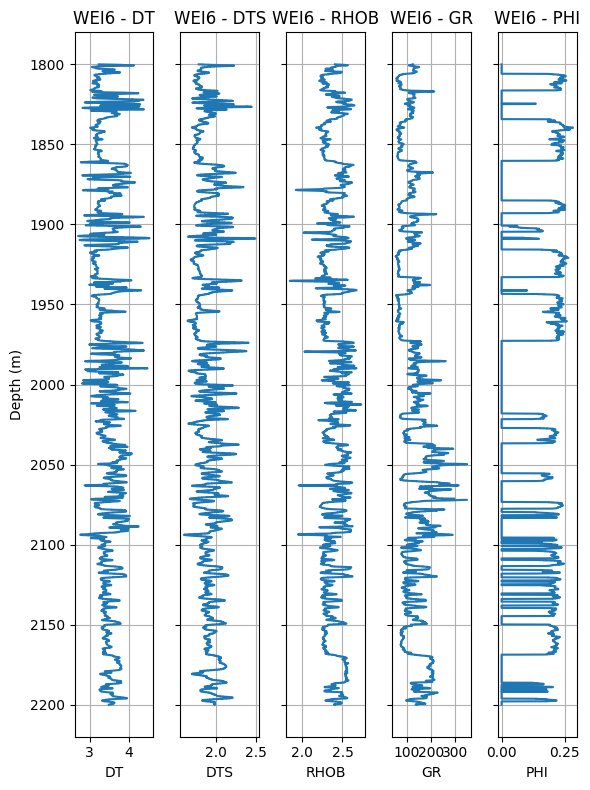

In [318]:
fig, axes = plt.subplots(1, 5, figsize=(6, 8), sharey=True)

depth = df_new.index.values  # 假设 index 就是 DEPTH

# -------- 子图1：SH --------
axes[0].plot(df_new["DT"], depth)
axes[0].set_xlabel("DT")
axes[0].set_ylabel("Depth (m)")
axes[0].set_title("WEI6 - DT")
axes[0].invert_yaxis()   # 深度向下增加
axes[0].grid(True)

# -------- 子图2：SW --------
axes[1].plot(df_new["DTS"], depth)
axes[1].set_xlabel("DTS")
axes[1].set_title("WEI6 - DTS")
axes[1].grid(True)

# -------- 子图3：RHOB --------
axes[2].plot(df_new["RHOB"], depth)
axes[2].set_xlabel("RHOB")
axes[2].set_title("WEI6 - RHOB")
axes[2].grid(True)

# -------- 子图4：GR --------
axes[3].plot(df_new["GR"], depth)
axes[3].set_xlabel("GR")
axes[3].set_title("WEI6 - GR")     

# PHI
axes[4].plot(df_new["PHI"], depth)
axes[4].set_xlabel("PHI")
axes[4].set_title("WEI6 - PHI")

plt.tight_layout()
plt.show()

Target Depths SH Values:
Depth: 1944.5 (nearest: 1944.52), SH: 0.0156
Depth: 2030.5 (nearest: 2030.48), SH: 0.0609
Depth: 2391.8 (nearest: 2199.95), SH: 0.3787
Depth: 2396.2 (nearest: 2199.95), SH: 0.3787


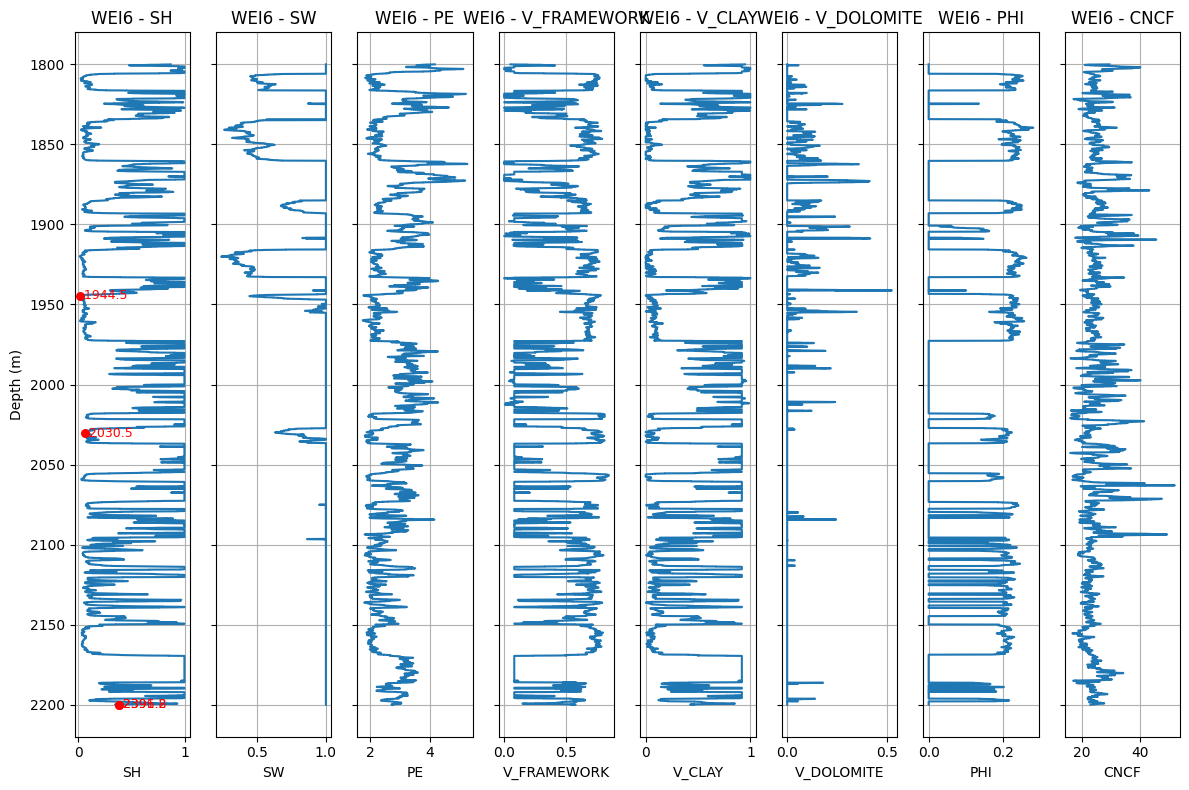

In [319]:
fig, axes = plt.subplots(1, 8, figsize=(12, 8), sharey=True)

depth = df_new.index.values  # 假设 index 就是 DEPTH

# -------- 子图1：SH --------
axes[0].plot(df_new["SH"], depth)
axes[0].set_xlabel("SH")
axes[0].set_ylabel("Depth (m)")
axes[0].set_title("WEI6 - SH")
axes[0].invert_yaxis()   # 深度向下增加
axes[0].grid(True)

# === 标注特定深度 ===
target_depths = [1944.5, 2030.5, 2391.8, 2396.2]
print("Target Depths SH Values:")
for d in target_depths:
    # 找最近的深度索引
    idx = (np.abs(df_new.index - d)).argmin()
    real_depth = df_new.index[idx]
    sh_val = df_new["SH"].iloc[idx]
    
    print(f"Depth: {d} (nearest: {real_depth:.2f}), SH: {sh_val:.4f}")
    
    # 在图上标红点
    axes[0].scatter(sh_val, real_depth, color='red', s=30, zorder=10)
    # 标文字
    axes[0].text(sh_val, real_depth, f" {d}", color='red', fontsize=9, verticalalignment='center')

# -------- 子图2：SW --------
axes[1].plot(df_new["SW"], depth)    
axes[1].set_xlabel("SW")
axes[1].set_title("WEI6 - SW")    
axes[1].grid(True)

#  PE
axes[2].plot(df_new["PE"], depth)
axes[2].set_xlabel("PE")
axes[2].set_title("WEI6 - PE")
axes[2].grid(True)

# V_FRAMEWORK
axes[3].plot(df_new["V_FRAMEWORK"], depth)    
axes[3].set_xlabel("V_FRAMEWORK")
axes[3].set_title("WEI6 - V_FRAMEWORK")    
axes[3].grid(True)

# V_CLAY
axes[4].plot(df_new["V_CLAY"], depth)    
axes[4].set_xlabel("V_CLAY")
axes[4].set_title("WEI6 - V_CLAY")
axes[4].grid(True)

# V_DOLOMITE
axes[5].plot(df_new["V_DOLOMITE"], depth)    
axes[5].set_xlabel("V_DOLOMITE")
axes[5].set_title("WEI6 - V_DOLOMITE")
axes[5].grid(True)

#phi
axes[6].plot(df_new["PHI"], depth)
axes[6].set_xlabel("PHI")
axes[6].set_title("WEI6 - PHI")
axes[6].grid(True)

# cncf
axes[7].plot(df_new["CNCF"], depth)
axes[7].set_xlabel("CNCF")
axes[7].set_title("WEI6 - CNCF")
axes[7].grid(True)

plt.tight_layout()
plt.show()

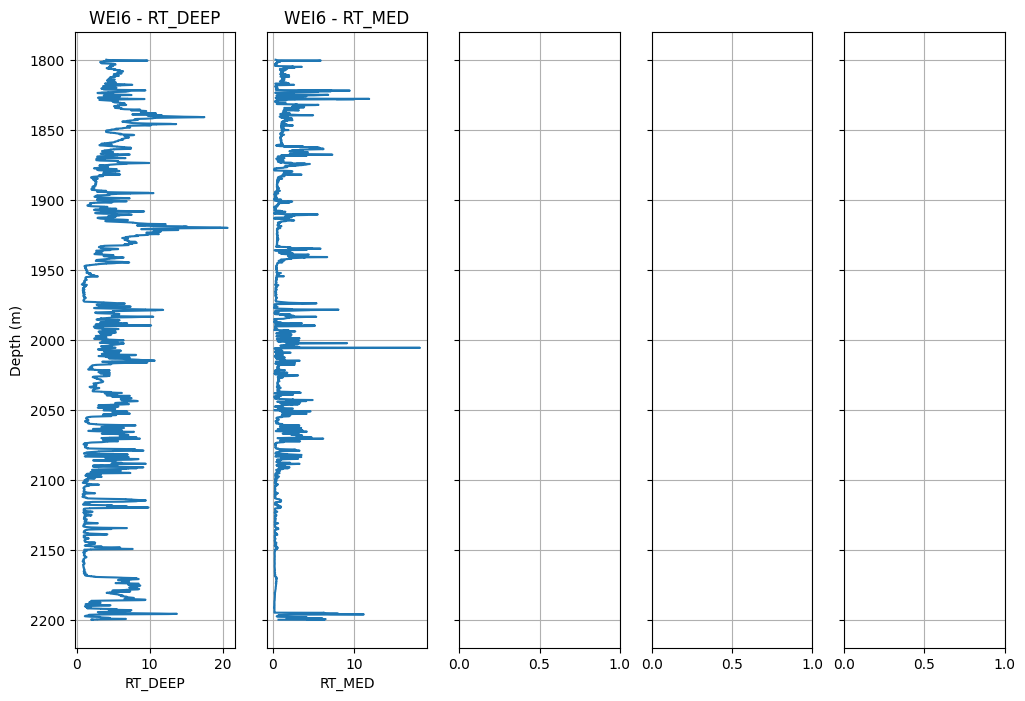

In [320]:
fig, axes = plt.subplots(1, 5, figsize=(12, 8), sharey=True)

depth = df_new.index.values  # 假设 index 就是 DEPTH

# -------- 子图1：RT-DEEP --------
axes[0].plot(df_new["RT_DEEP"], depth)
axes[0].set_xlabel("RT_DEEP")
axes[0].set_ylabel("Depth (m)")
axes[0].set_title("WEI6 - RT_DEEP")
axes[0].invert_yaxis()   # 深度向下增加
axes[0].grid(True)

# -------- 子图2：RT-MED --------
axes[1].plot(df_new["RT_MED"], depth)
axes[1].set_xlabel("RT_MED")
axes[1].set_title("WEI6 - RT_MED")
axes[1].grid(True)


In [321]:
# ========== 1.1 矿物弹性模量 & 密度库 ==========
# 单位：K,G 用 GPa，rho 用 g/cm3（和 Mavko 那套一致，后面算波速方便）
MINERAL_DB = {
    "quartz":      {"K": 37.0, "G": 44.0, "rho": 2.65},
    # K长石
    "k_feldspar":  {"K": 37.0, "G": 25.0, "rho": 2.56},
    # 斜长石
    "plagioclase": {"K": 75.0, "G": 30.0, "rho": 2.68},
    # 岩屑   可以看成“火山岩 / 变质岩碎屑 + 少量泥质”的综合，先给一个中等偏软的值
    "lithics":     {"K": 25.0, "G": 12.0, "rho": 2.65},
    # SH    (印兴耀 和 刘倩, 2016, p. 55)
    "shale":       {"K": 21.0, "G": 7.0,  "rho": 2.60},
    # 白云石 (Mavko et al.)
    "dolomite":    {"K": 94.9, "G": 45.0, "rho": 2.87},
    
    # === 混合骨架 (Framework) ===
    # 基于之前组分(石英+长石+岩屑)估算的平均值
    "framework":   {"K": 34.6, "G": 29.3, "rho": 2.65}, 
}

# ========== 1.2 岩相薄片平均组分 ==========
# 根据薄片统计 ： 石英 62.4%，K长石 6.4%，斜长石 4.3%，岩屑 26.2%
SAND_COMPOSITION  = {
    "quartz":      62.4,
    "k_feldspar":  6.4,
    "plagioclase": 4.3,
    "lithics":     26.2,
}

# ================= 1.3 流体性质库 =================
# 单位：K 用 GPa，rho 用 g/cm3
FLUID_DB = {
    # 含盐水/地层水
    "water": { "K": 2.3, "rho": 1.07,},
    "oil":   { "K": 1.1, "rho": 0.85,},
    "gas":   { "K": 0.05, "rho": 0.2,},
}

In [322]:
def add_background_mineral_moduli(df_logs,
                                  sh_col="SH",
                                  v_frame_col="V_FRAMEWORK",
                                  v_clay_col="V_CLAY",
                                  v_dolo_col="V_DOLOMITE",
                                  sh_to_vsh=0.01,
                                  vsh_clip=1.0,      # Vsh 上限
                                  mineral_db=None):
    """
    计算整口井的混合矿物体积模量 Km、剪切模量 Gm、密度 RHOm（VRH平均）。
    直接使用 'framework' 矿物属性，不再进行砂岩组分拆分。
    """
    if mineral_db is None:
        mineral_db = MINERAL_DB

    df_out = df_logs.copy()
    n_depth = len(df_out)

    # 矿物列表：[framework, shale, dolomite]
    mineral_names = ["framework", "shale", "dolomite"]
    n_minerals    = len(mineral_names)
    
    # 初始化体积分数矩阵
    f_matrix = np.zeros((n_depth, n_minerals), dtype=float)

    # 检查是否可以使用三条矿物曲线
    has_min_curves = all(c in df_out.columns for c in [v_frame_col, v_clay_col, v_dolo_col])
    
    if has_min_curves:
        if df_out[v_frame_col].isna().all() or df_out[v_clay_col].isna().all():
            has_min_curves = False

    if has_min_curves:
        print(">>> 使用 V_FRAMEWORK / V_CLAY / V_DOLOMITE 计算矿物模量...")
        # 1. 读取曲线并填 0
        V_frame = df_out[v_frame_col].fillna(0.0).values
        V_clay  = df_out[v_clay_col].fillna(0.0).values
        V_dolo  = df_out[v_dolo_col].fillna(0.0).values
        
        # 2. 归一化为固体体积分数 (Sum = 1)
        V_total = V_frame + V_clay + V_dolo
        mask_valid = V_total > 1e-5
        
        # 归一化
        f_matrix[mask_valid, 0] = V_frame[mask_valid] / V_total[mask_valid] # framework
        f_matrix[mask_valid, 1] = V_clay[mask_valid]  / V_total[mask_valid] # shale
        f_matrix[mask_valid, 2] = V_dolo[mask_valid]  / V_total[mask_valid] # dolomite
        
        vsh = f_matrix[:, 1]

    else:
        print(f">>> 未找到完整矿物曲线，使用 {sh_col} 估算...")
        # ---------- 1) SH -> Vsh ----------
        SH = df_out[sh_col].to_numpy(dtype=float)
        vsh = SH * sh_to_vsh
        vsh = np.clip(vsh, 0.0, vsh_clip)
        vsand = 1.0 - vsh
        
        # 砂岩部分 -> framework
        f_matrix[:, 0] = vsand
        # 泥质部分 -> shale
        f_matrix[:, 1] = vsh
        # 白云石 -> 0
        f_matrix[:, 2] = 0.0

    # ---------- 3) VRH 混合 K、G，Voigt 混合密度 ----------
    # 确保 DB 里有所有矿物
    for m in mineral_names:
        if m not in mineral_db:
            print(f"Warning: {m} not in MINERAL_DB, using quartz properties.")
            mineral_db[m] = mineral_db["quartz"]

    K_list   = np.array([mineral_db[n]["K"]   for n in mineral_names], dtype=float)
    G_list   = np.array([mineral_db[n]["G"]   for n in mineral_names], dtype=float)
    rho_list = np.array([mineral_db[n]["rho"] for n in mineral_names], dtype=float)

    # Voigt
    K_V = np.sum(f_matrix * K_list[None, :], axis=1)
    G_V = np.sum(f_matrix * G_list[None, :], axis=1)
    # Reuss
    K_R = 1.0 / np.sum(f_matrix / K_list[None, :], axis=1)
    G_R = 1.0 / np.sum(f_matrix / G_list[None, :], axis=1)

    Km = 0.5 * (K_V + K_R)
    Gm = 0.5 * (G_V + G_R)

    RHOm = np.sum(f_matrix * rho_list[None, :], axis=1)

    # ---------- 4) 写回 df ----------
    df_out["Vsh"]    = vsh
    df_out["K_m"]    = Km
    df_out["G_m"]    = Gm
    df_out["RHO_m"]  = RHOm

    return df_out

In [323]:
df_bg = add_background_mineral_moduli(df_new, 
                                      sh_col="SH", 
                                      v_frame_col="V_FRAMEWORK",
                                      v_clay_col="V_CLAY",
                                      v_dolo_col="V_DOLOMITE",
                                      sh_to_vsh=1.0, 
                                      vsh_clip=1.0, 
                                      mineral_db=MINERAL_DB)

df_bg[["Vsh", "K_m", "G_m", "RHO_m"]].head()

>>> 使用 V_FRAMEWORK / V_CLAY / V_DOLOMITE 计算矿物模量...


,Vsh,K_m,G_m,RHO_m
DEPTH,,,,
1800.04736,0.948699,21.564935,7.714220,2.602565
1800.12366,0.928408,21.790849,7.999944,2.603580
1800.19983,0.814815,23.083549,9.639050,2.609259
1800.27600,0.814815,23.083549,9.639050,2.609259
1800.35217,0.698058,24.467185,11.410960,2.615097


In [324]:
# ================= 构造背景刚度矩阵 C_bg（对每个深度点）：  =================

# --------- 背景矿物模量（GPa） ---------
K_bg = df_bg["K_m"].values       # GPa
G_bg = df_bg["G_m"].values       # GPa

# --------- 总孔隙度 ---------
phi_tot = np.clip(df_bg["PHI"].values, 0.0, 0.5)

# --------- vrh_f：这里我们不依赖“f=1 的特殊分支”，直接给 0 即可 ---------
N1 = len(df_bg)
vrh_f = np.zeros((N1, 1), dtype=float)

# --------- 组装 ix1 = [K, mu] ---------
ix1 = np.column_stack([K_bg, G_bg])

B_m = 41  #  Backus平均的点数，该值须为奇数

CM_backus = Backus_mult241016(
    ix1=ix1,       # [K_bg, G_bg]
    #  修改：这里传0，孔隙在DEM加 
    phit=phi_tot,  # (N1,)  phi_tot
    vrh_f=vrh_f,   # (N1,1)，这里只为了通过函数接口
    B_m=B_m
)
# CM_backus 形状：(6, 6, N1)
print("CM_backus shape:", CM_backus.shape)

CM_backus shape: (6, 6, 5249)


In [ ]:
def add_fluid_mixture_wood(
    df: pd.DataFrame,
    sw_col: str = "SW",
    fluid_db: dict = FLUID_DB
) -> pd.DataFrame:
    """
    用统一端点(水 + 油)做全井流体混合：
    - ρ_fl = Sw * ρ_w + (1-Sw) * ρ_o
    - 1/K_fl = Sw/K_w + (1-Sw)/K_o  (Wood 混合)

    单位：
    - ρ 用 g/cm3
    - K 用 GPa
    """

    df2 = df.copy()

    # 1) 取 SW，并转成 0–1，顺便裁剪一下
    sw_raw = df2[sw_col].astype(float).values
    sw_frac = np.clip(sw_raw , 0, 1.0)

    rho_w = fluid_db["water"]["rho"]
    K_w   = fluid_db["water"]["K"]
    rho_o = fluid_db["oil"]["rho"]
    K_o   = fluid_db["oil"]["K"]

    # 2) 密度线性混合
    rho_fl = sw_frac * rho_w + (1.0 - sw_frac) * rho_o

    # 3) 体积模量 Wood 混合
    inv_K_fl = sw_frac / K_w + (1.0 - sw_frac) / K_o
    K_fl = 1.0 / inv_K_fl

    # 4) 写回 DataFrame
    df2["SW_frac"] = sw_frac   # 0–1 的含水饱和度
    df2["RHO_fl"]  = rho_fl    # g/cm3
    df2["K_fl"]    = K_fl      # GPa

    return df2


df_bg = add_fluid_mixture_wood(df_bg, sw_col="SW", fluid_db=FLUID_DB)
df_bg[["SW", "SW_frac", "RHO_fl", "K_fl"]].head()

In [326]:

# 裂缝孔隙度估算

LLD = df_bg["RT_DEEP"].to_numpy()
LLS = df_bg["RT_MED"].to_numpy()
SW  = df_bg["SW"].to_numpy() 

# 1) 裂缝判别指数 Y
Y = (LLD - LLS) / np.sqrt(LLD * LLS)

# 2) 分段给 A1/A2/A3
A1 = np.zeros_like(Y)
A2 = np.zeros_like(Y)
A3 = np.zeros_like(Y)

mask1 = (Y < 0)
A1[mask1] = -0.992417
A2[mask1] =  1.97247
A3[mask1] =  0.000318291

mask2 = (Y > 0) & (Y < 0.1)
A1[mask2] = -17.6332
A2[mask2] =  20.36451
A3[mask2] =  0.00093177

mask3 = (Y > 0.1)
A1[mask3] =  8.522532
A2[mask3] = -8.242788
A3[mask3] =  0.00071236

r_mf = 0.2
phi_f2 = (A1/LLS + A2/LLD + A3) * r_mf    # 裂缝孔隙度（初算）

# 3) 用总孔隙度约束：phi_f2 <= 0.3 * phi_tot
phi_tot = df_bg["PHI"].to_numpy()  # 如果是百分比
# 裂缝孔隙度不超过 0.3 * φ_total
phi_f2 = np.minimum(phi_f2, 0.3 * phi_tot)

# 4) 数量级调整 + 含气调制 (sg = 1 - sw)
phi_f2 = phi_f2 * 0.1
sg = 1.0 - SW   

phi_f3 = sg * 0.01
phi_f4 = 0.6 * sg * 0.005 + 0.4 * phi_f2

# 裂缝孔隙度
phi_frac   = phi_f4                 
# 基质孔隙度     认为它主要以“球形 / 低长径比孔洞”的形式存在于基质里。
phi_matrix = phi_tot - phi_frac     

df_bg["PHI_frac"]   = phi_frac
df_bg["PHI_matrix"] = phi_matrix



In [327]:
def add_matrix_pores_with_dem(CM_backus, K_fluid, phi_matrix, aspect_ratio=0.12,
                              dv=0.01, errmax=1e-2):
    """
    在 VTI 背景刚度 CM_backus 上，用 DEM 加入“基质孔隙 PHI_matrix”，
    得到含基质孔隙的干岩刚度 C_dem。
    ----
    CM_backus : (6,6,N) ndarray
        Backus 平均后的 VTI 背景刚度矩阵（现在的 CM_backus）。
    K_fluid : (N,) ndarray
        Wood 公式得到的混合流体体积模量 (Pa)，在 DEM 里作为“孔隙相”的体积模量。
    phi_matrix : (N,) ndarray
        基质孔隙度（小数 0~0.5），= 总孔隙度 - 裂缝孔隙度。
    dv : float
        DEM 的体积分数步长（每次增加多少孔隙体积分数），默认 0.01。
    errmax : float
        Green 张量积分精度控制参数，对应 dem_ani 里的 errmax。

    返回   C_dem : (6,6,N)    加入基质孔隙后的等效干岩刚度。
    """
    CM_backus = np.asarray(CM_backus, dtype=float)
    K_fluid = np.asarray(K_fluid, dtype=float)
    phi_matrix = np.asarray(phi_matrix, dtype=float)

    n_depth = CM_backus.shape[2]
    assert K_fluid.shape[0] == n_depth
    assert phi_matrix.shape[0] == n_depth

    # 输出
    C_dem = np.zeros_like(CM_backus)

    # DEM 模型几何/形状：两相，均视为各向同性球形
    # ioptel: 1 = 各向同性
    ioptel = np.array([[1],
                       [1]], dtype=int)
    # ioptoe: 1 = 球形
    ioptoe = np.array([[1],
                       [1]], dtype=int)
    # axis: 每个相的椭球半轴，这里都用 [1,1,1] 表示球
    axis = np.array([[1.0, 1.0, 1.0],
                     [aspect_ratio, aspect_ratio, 1.0]], dtype=float)

    # 方向相关参数（我们用各向同性球形，可以随便给一个）
    al = 90.0
    xl = 0.0
    af = 0.0
    xf = 0.0

    # 两相：0 = 背景固体，1 = 孔隙+流体 相
    NMIN = 2
    idem = 2      # inclusion 相的编号 = 2（MATLAB 里是 1/2，这里 dem_ani 内部做了 -1）

    for i in range(n_depth):
        # 这一深度点的基质孔隙度
        phi2 = float(np.clip(phi_matrix[i], 0.0, 0.5))
        if not np.isfinite(phi2) or phi2 <= 0.0:
            # 没有基质孔隙或无效值：直接用原始 Backus 刚度
            C_dem[:, :, i] = CM_backus[:, :, i]
            continue

        # --------------- 组装 M 字典，传给 dem_ani ----------------
        M = {}

        # 两相刚度：相1 = 背景刚度，相2 = 孔隙+流体 (K_fluid, μ=0)
        myEC = np.zeros((6, 6, NMIN), dtype=float)
        myEC[:, :, 0] = CM_backus[:, :, i]             # 背景相
        K_air = 1e-6  # GPa
        myEC[:, :, 1] = ku2c(K_air, 0.0)          # 孔隙相

        M["myEC"]   = myEC
        M["errmax"] = errmax
        M["ioptel"] = ioptel
        M["ioptoe"] = ioptoe
        M["axis"]   = axis
        M["al"]     = al
        M["xl"]     = xl
        M["af"]     = af
        M["xf"]     = xf
        M["idem"]   = idem       # 第 2 相是 inclusion，相当于“往背景里加软相”
        M["NMIN"]   = NMIN

        # DEM 路径：从 Vb = 0 增加到 Vb = phi2
        M["v1"] = 0.0
        M["v2"] = phi2
        M["dv"] = dv

        # --------------- 真正调用 dem_ani ----------------
        vliq, Cmx = dem_ani(M)   # vliq 是体积分数路径，Cmx 是最终刚度 (6x6)

        C_dem[:, :, i] = Cmx

    return C_dem

In [328]:
# ================== DEM ==================
phi_matrix = df_bg["PHI_matrix"].to_numpy()      # 基质孔隙度，小数
K_fl = df_bg["K_fl"].to_numpy()     # (N,) GPa


C_dem = add_matrix_pores_with_dem(
    CM_backus=CM_backus,
    K_fluid=K_fl,                    # 这个参数现在不影响了（内部用K_air）
    phi_matrix=phi_matrix,           # 基质孔隙度
    aspect_ratio=0.12,
    dv=0.01,
    errmax=1e-2
)

# ========== 然后在 C_dem 上做 Brown–Korringa（只对裂缝孔隙度） ==========
# C_dem = add_matrix_pores_with_dem(CM_backus, K_fl, phi_matrix)



KeyError: 'K_fl'

In [ ]:
i0 = 100  # 任意选一个深度点

print("Depth ~", df_bg.index[i0])
print("Backus C33:", CM_backus[2, 2, i0])
print("DEM    C33:", C_dem[2, 2, i0])

Depth ~ 1807.66736
Backus C33: 72.83862411018617
DEM    C33: 41.1920910017669


In [ ]:
# ================== Schoenberg ==================

# 1) 裂缝孔隙度（0~1）
phi_frac = phi_frac

# 2) 设定一个固定的裂缝纵横比 X（例如 0.01）
X_frac = 0.01
X_arr = np.full_like(phi_frac, X_frac, dtype=float)

# 3) hudm 组装成 (N,4)，HTI 模式只用到前两列，后两列给 0 占位即可
hudm = np.column_stack([
    phi_frac,           # 裂缝孔隙度
    X_arr,              # 裂缝纵横比
    np.zeros_like(phi_frac),  # 占位
    np.zeros_like(phi_frac),  # 占位
])

# 4) 调用 Schoenberg，背景刚度用 DEM 之后的 C_dem
C_dem = C_dem  # 变量名不变
Chud = Schoenberg(C_dem, hudm, mode="HTI")   # (6,6,N)


In [ ]:
# ================== BKG ==================
# BKG 会沿着深度逐点做各向异性流体替换

N = Chud.shape[2]

# 1) 背景矿物体积模量（GPa）
K_bg = K_bg

# 2) 流体体积模量（GPa）
K_fl = K_fl   # (N,)

# 3) 只用“裂缝孔隙度”做 Brown-Korringa 的 phi
phi_frac = phi_frac         

# 4) 组装 m_bkg: (N,3) [km, kfl, phi]
m_bkg = np.column_stack([K_bg, K_fl, phi_frac])   # (N, 3)

# 5) 调用 BKG，对 Chud 做各向异性流体替换
Cbkg  = BKG(Chud, m_bkg)

# ================== 处理极端点 ==================
# 条件 1：总孔隙度极小 → BKG 数值最容易炸，且物理上流体效应也很弱
mask_tiny_tot = phi_tot < 0.005
# 条件 2：裂缝孔隙度极小 → 裂缝流体对整体刚度影响可以忽略
mask_tiny_frac = phi_frac < 1e-4
mask_skip_bkg = mask_tiny_tot | mask_tiny_frac
print("skip BKG 点数：", mask_skip_bkg.sum())
Cbkg_final = Cbkg.copy()
# 对需要跳过 BKG 的位置，用 Chud 覆盖
Cbkg_final[:, :, mask_skip_bkg] = Chud[:, :, mask_skip_bkg]


skip BKG 点数： 2911


In [ ]:
# ==================  计算等效密度 ==================
# 简单体积平均：ρ = (1-φ)*ρ_mineral + φ*ρ_fluid
rho_m = df_bg["RHO_m"].to_numpy()   # g/cm3 
rho_fl = df_bg["RHO_fl"].to_numpy()  # g/cm3 

rho_bulk = (1.0 - phi_tot) * rho_m + phi_tot * rho_fl   # (N,), g/cm3

rho_bulk_si = rho_bulk * 1000.0      # kg/m3

# ==================  从刚度矩阵先算一遍“模型 Vp” ==================
# 先用当前的 Cbkg_final 跑一次 C2T，当做未校正的模型结果
m0_pre, m1_pre, m2_pre = C2T(Cbkg_final, rho_bulk)
Vp_model = m2_pre[:, 0] 

vp_log = (df_bg["DT"].to_numpy(dtype=float) ) * 1000.0    # m/s

# ==================  计算逐深度刚度缩放因子 alpha(z) ==================
alpha = np.ones_like(Vp_model)

alpha = (vp_log / Vp_model)**2
# ==================  对刚度矩阵逐深度缩放，得到最终 C_OA ==================
C_OA = Cbkg_final.copy()   # (6,6,N)
N = C_OA.shape[2]

for k in range(N):
    if np.isfinite(alpha[k]) and alpha[k] > 0:
        C_OA[:, :, k] *= alpha[k]


In [ ]:

# ================== 4. 用 C2T 求 Vp / Vs / ε / δ / ZN/ZV/ZH ==================

# 先不进行约束
m0, m1, m2 = C2T(Cbkg_final, rho_bulk)

# m0, m1, m2 = C2T(C_OA, rho_bulk)

# m0: (N, 8) [M0, mu0, den, epsilon0, delta0, ZN, ZV, ZH]
# m1: OA  9参数  ：(N, 9) [Vp0, Vs0, epsilon1, epsilon2, gamma1, gamma2, delta1, delta2, delta3]  (Tsvankin参数)
# m2: VTI 8参数  ：(N, 8) [Vp, Vs, den, epsilon0, delta0, ZN, ZV, ZH（正交各向异性背景下的三方向阻抗）]

Vp_OA = m2[:, 0]      # m/s
Vs_OA = m2[:, 1]      # m/s
Den_OA = m2[:, 2]     # kg/m3
Eps0  = m2[:, 3]
Del0  = m2[:, 4]
ZN    = m2[:, 5]
ZV    = m2[:, 6]
ZH    = m2[:, 7]

# -------- 2) OA 各向异性参数（来自 m1） --------
eps1  = m1[:, 2]
eps2  = m1[:, 3]
gam1  = m1[:, 4]
gam2  = m1[:, 5]
del1  = m1[:, 6]
del2  = m1[:, 7]
del3  = m1[:, 8]


# 把结果并回 df_bg，生成一个带各向异性结果的新 DataFrame
df_ani = df_bg.copy()
df_ani["VP_OA"]   = Vp_OA
df_ani["VS_OA"]   = Vs_OA
df_ani["DEN_OA"]  = Den_OA / 1000.0   # 转回 g/cm3 看起来更直观
df_ani["EPSILON"] = Eps0
df_ani["DELTA"]   = Del0
df_ani["ZN"]      = ZN
df_ani["ZV"]      = ZV
df_ani["ZH"]      = ZH

# 正交各向异性完整参数
df_ani["EPS1"]  = eps1
df_ani["EPS2"]  = eps2
df_ani["GAM1"]  = gam1
df_ani["GAM2"]  = gam2
df_ani["DEL1"]  = del1
df_ani["DEL2"]  = del2
df_ani["DEL3"]  = del3

df_ani[["VP_OA","VS_OA","DEN_OA","EPSILON","DELTA"]].head()


,VP_OA,VS_OA,DEN_OA,EPSILON,DELTA
DEPTH,,,,,
1800.04736,3727.592647,1927.708609,0.002603,0.008676,-0.008784
1800.12366,3726.866329,1927.332997,0.002604,0.008676,-0.008784
1800.19983,3722.807926,1925.234212,0.002609,0.008676,-0.008784
1800.27600,3722.807926,1925.234212,0.002609,0.008676,-0.008784
1800.35217,3718.619049,1923.051498,0.002615,0.008678,-0.008787


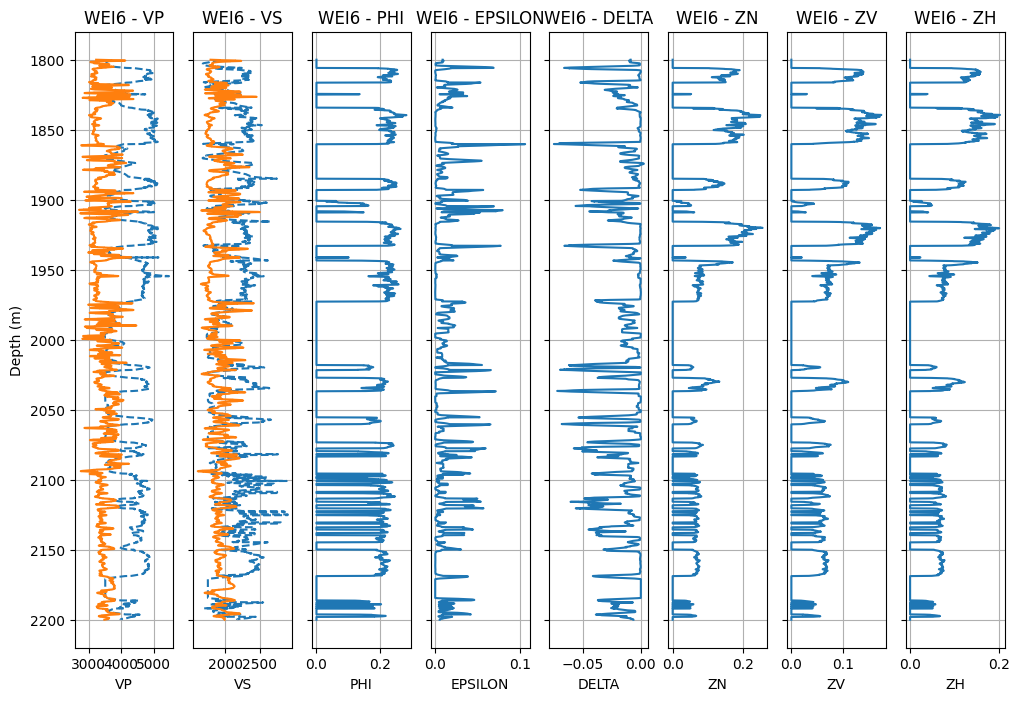

In [ ]:
fig, axes = plt.subplots(1, 8, figsize=(12, 8), sharey=True)

depth = df_new.index.values  # 假设 index 就是 DEPTH

# -------- 子图1：VP --------
axes[0].plot(df_ani["VP_OA"], depth, label="Vp_OA", linestyle="--")
axes[0].plot(vp_log, depth, label="Vp_log")
axes[0].set_xlabel("VP")
axes[0].set_ylabel("Depth (m)")
axes[0].set_title("WEI6 - VP")
axes[0].invert_yaxis()   # 深度向下增加
axes[0].grid(True)

# -------- 子图2：VS --------
axes[1].plot(df_ani["VS_OA"], depth, label="Vs_OA", linestyle="--")
axes[1].plot(df_ani["DTS"]*1000, depth, label="Vs_log")
axes[1].set_xlabel("VS")
axes[1].set_title("WEI6 - VS")
axes[1].grid(True)      

#   ----- 子图3：DEN --------
axes[2].plot(df_ani["PHI"], depth)     
axes[2].set_xlabel("PHI")
axes[2].set_title("WEI6 - PHI")
axes[2].grid(True)

#  ----- 子图4：EPSILON --------
axes[3].plot(df_ani["EPSILON"], depth)     
axes[3].set_xlabel("EPSILON")
axes[3].set_title("WEI6 - EPSILON")
axes[3].grid(True)

# ----- 子图5：DELTA --------
axes[4].plot(df_ani["DELTA"], depth)     
axes[4].set_xlabel("DELTA")
axes[4].set_title("WEI6 - DELTA")
axes[4].grid(True)

# ----- 子图6：ZN --------
axes[5].plot(df_ani["ZN"], depth)     
axes[5].set_xlabel("ZN")
axes[5].set_title("WEI6 - ZN")
axes[5].grid(True)

# ----- 子图7：ZV --------
axes[6].plot(df_ani["ZV"], depth)     
axes[6].set_xlabel("ZV")
axes[6].set_title("WEI6 - ZV")
axes[6].grid(True)

# ----- 子图8：ZH --------
axes[7].plot(df_ani["ZH"], depth)     
axes[7].set_xlabel("ZH")
axes[7].set_title("WEI6 - ZH")
axes[7].grid(True)

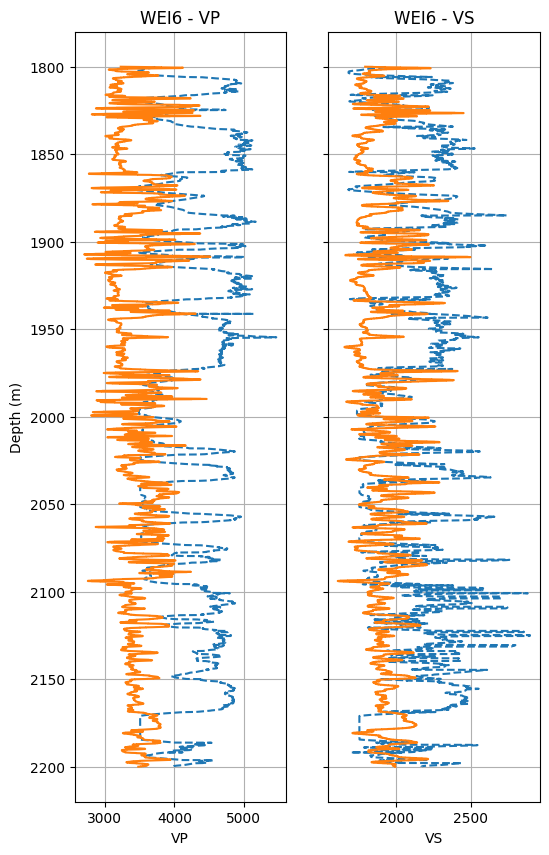

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 10), sharey=True)

depth = df_new.index.values  # 假设 index 就是 DEPTH

# -------- 子图1：VP --------
axes[0].plot(df_ani["VP_OA"], depth, label="Vp_OA", linestyle="--")
axes[0].plot(vp_log, depth, label="Vp_log")
axes[0].set_xlabel("VP")
axes[0].set_ylabel("Depth (m)")
axes[0].set_title("WEI6 - VP")
axes[0].invert_yaxis()   # 深度向下增加
axes[0].grid(True)

# -------- 子图2：VS --------
axes[1].plot(df_ani["VS_OA"], depth, label="Vs_OA", linestyle="--")
axes[1].plot(df_ani["DTS"]*1000, depth, label="Vs_log")
axes[1].set_xlabel("VS")
axes[1].set_title("WEI6 - VS")
axes[1].grid(True)     

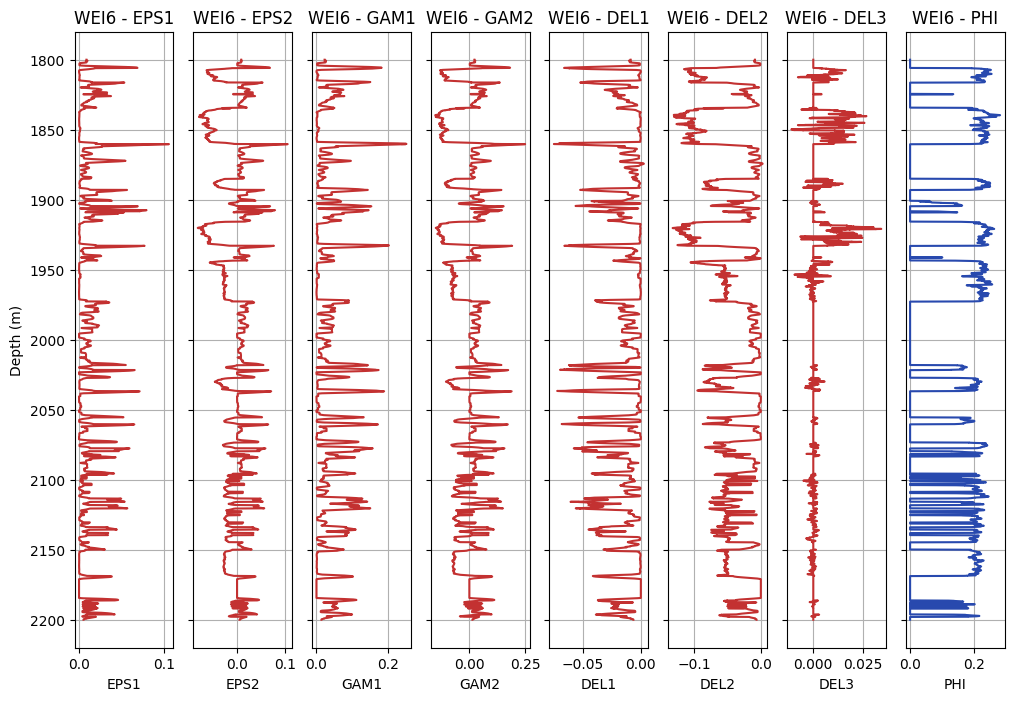

In [ ]:
fig, axes = plt.subplots(1, 8, figsize=(12, 8), sharey=True)

depth = df_new.index.values  # 假设 index 就是 DEPTH

# -------- 子图1：EPS1 --------
axes[0].plot(df_ani["EPS1"], depth, label="EPS1", color="#C33131")
axes[0].set_xlabel("EPS1")
axes[0].set_ylabel("Depth (m)")
axes[0].set_title("WEI6 - EPS1")
axes[0].invert_yaxis()   # 深度向下增加
axes[0].grid(True)
# -------- 子图2：EPS2 --------
axes[1].plot(df_ani["EPS2"], depth, label="EPS2", color="#C33131")
axes[1].set_xlabel("EPS2")
axes[1].set_title("WEI6 - EPS2")
axes[1].grid(True)
# -------- 子图3：GAM1 --------
axes[2].plot(df_ani["GAM1"], depth, label="GAM1", color="#C33131")
axes[2].set_xlabel("GAM1")
axes[2].set_title("WEI6 - GAM1")
axes[2].grid(True)
# -------- 子图4：GAM2 --------
axes[3].plot(df_ani["GAM2"], depth, label="GAM2", color="#C33131")
axes[3].set_xlabel("GAM2")
axes[3].set_title("WEI6 - GAM2")
axes[3].grid(True)
# -------- 子图5：DEL1 --------
axes[4].plot(df_ani["DEL1"], depth, label="DEL1", color="#C33131")
axes[4].set_xlabel("DEL1")
axes[4].set_title("WEI6 - DEL1")
axes[4].grid(True)
# -------- 子图6：DEL2 --------
axes[5].plot(df_ani["DEL2"], depth, label="DEL2", color="#C33131")
axes[5].set_xlabel("DEL2")
axes[5].set_title("WEI6 - DEL2")
axes[5].grid(True)
# -------- 子图7：DEL3 --------
axes[6].plot(df_ani["DEL3"], depth, label="DEL3", color="#C33131")
axes[6].set_xlabel("DEL3")
axes[6].set_title("WEI6 - DEL3")
axes[6].grid(True)
# -------- 子图8：PHI --------
axes[7].plot(df_ani["PHI"], depth, label="PHI", color="#2849AE")
axes[7].set_xlabel("PHI")
axes[7].set_title("WEI6 - PHI")
axes[7].grid(True)